In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [2]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [3]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [4]:
def add_seasonal_simple(df, col='Date', start='2017-01-01'):
    # Add a very simplistic seasonal regressors as cos and sin since some date in a year
    time_delta = df[col] - np.datetime64(start)
    time_delta_rad = time_delta.apply(lambda d: d.days) * 2 * np.pi / 365.25
    df['Seasonal (sin)'] = np.sin(time_delta_rad)
    df['Seasonal (cos)'] = np.cos(time_delta_rad)

In [5]:
def Ftest(model, var_prefix):
    var_columns = [c for c in model.params.index if c.startswith(var_prefix)]
    if var_columns:
        f_test = model.f_test(' = '.join(var_columns) + " = 0")
        print("%s F-test: %s" % (var_prefix, f_test))
        return f_test
    else:
        print("No %s variables in the model" % var_prefix)
        return None

In [138]:
def regress(target_variable, model_df, plot=True, print_summary=True):
    # creates a regression graph plotted against actual data from certain QA metrics
    #      target_variable: takes str value of either snr_total or tsnr to model against
    #      model_df       : takes pandas DataFrame with data to be used for predictive modeling
    #      plot           : boolean to turn the plotted graph on/off
    
    if type(model_df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    
    
    ########## adding seasonal curves to the model
    add_seasonal_simple(model_df)
    
    
    ########## Converting date to a format that can be parsed by statsmodels API
    model_df['Date'] = pd.to_datetime(model_df['Date'], format="%Y%m%d")
    model_df['Date2'] = model_df['Date'].map(pd.datetime.toordinal)
    
    # There is apparently a sample date (20170626) with SAR being unknown None/NaN
    # For now we will just filter out those samples
    if 'SAR' in model_df.columns:
        finite_SAR = np.isfinite(model_df['SAR'])
        if not np.all(finite_SAR):
            print("Following dates didn't have SAR, excluding them: %s" % str(model_df['Date'][~finite_SAR]))
            model_df = model_df[finite_SAR]
    
    
    ########## Assigning independent and dependent variables
    model_vars = []
    
    for item in model_df.std().iteritems():
        if item[0] != 'Date' and item[0] != target_variable:
            model_vars.append(item[0])

    X = model_df[model_vars]
    y = model_df[target_variable]
    X = X.sub(X.mean())
    X = sm.add_constant(X)
    
    model_df = sm.add_constant(model_df)
    
    
    ########## modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    
    
    ################ CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    significant_variables = [] 
    
    # get p-values
    for key, value in dict(model.pvalues).items():
        if value < 0.05 or key.lower() == 'const':
            # identify statistically insignificant variables in df
            significant_variables.append(key)
    
    
    
    ######## set statistically insignificant variables to 0, then predict
        
    partial_fits = {}  # partial_fits = {}

    for variable in significant_variables:

        X2 = model_df.copy(True) # prepare for mods
        X2 = X2[model_vars]
        X2 = sm.add_constant(X2)

        for col in X2:
            if col != variable:
                X2[col] = 0
        
        partial_fits[str(variable)] = model.predict(X2)
     
    if print_summary:
        print("Statistically significant variables: " + str(significant_variables))
    
    ################ END CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    
    if not plot:
        return model
    
    
    ######### converting the above predictions to a format that can be plotted
    
    plot_df = predictions.to_frame()       # new DataFrame containing only data needed for the plot
    plot_df.columns = ['full fit']
    plot_df = plot_df.join(model_df['Date'])
    plot_df = plot_df.join(model_df[target_variable])
    
    summation_df = None
    
    for key, value in partial_fits.items():
        column = value.to_frame()
        column.columns = ['partial fit']

        if summation_df is None:
            summation_df = column          # used to add up the values
        else:
            summation_df = summation_df.add(column, axis=1)
    
    plot_df = pd.concat([plot_df, summation_df], axis=1)
    
    # plotting the graph
    plt.figure(figsize=(15, 6))

    ax = sns.lineplot(x="Date", y=target_variable, data=plot_df, color="#000000")
    
    # plotting partial fit
    ax_partial = plt.twinx()
    sns.lineplot(x="Date", y="full fit", data=plot_df, color="r", ax=ax)
    if partial_fits:
        sns.lineplot(x="Date", y="partial fit", data=plot_df, color="#ffcccc", ax=ax_partial)
        plt.ylim(145, 305)
        ax_partial.legend(['partial fit'])
    
    ax.legend(['actual', 'full fit'], loc='upper left')
    
    # giving additional data
    if print_summary:
        print(model.summary())
    # print(model.pvalues['snr_total_qa'])
    
    F_shim = Ftest(model, 'Shim')
    F_IOPD = Ftest(model, 'IOPD')
    F_seasonal = Ftest(model, 'Seasonal')
    return model

In [8]:
#         #
#        # #
#       #   #
#      #     #
#     #########
#    #         #
#   #           #
#  #             #
# #               # NALYSES

All Conversion Softwares are the same: True


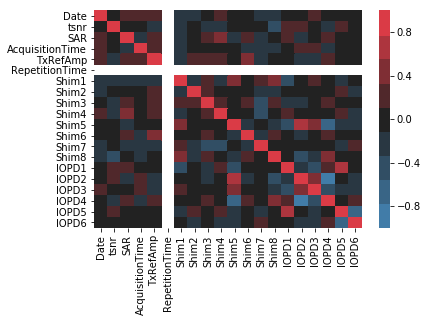

In [9]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


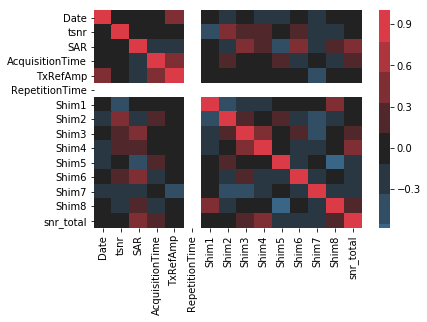

In [10]:
analyses('../data/extractions/p2_BOLD_snr.csv')

All Conversion Softwares are the same: True


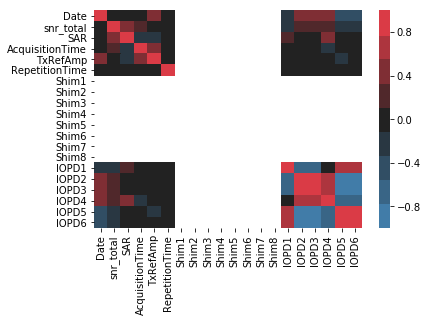

In [11]:
analyses('../data/extractions/anat.csv')

In [13]:
df = pd.read_csv('../data/extractions/p2_BOLD.csv', parse_dates=['Date'])
df

,Date,Filetype,tsnr,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,...,Shim5,Shim6,Shim7,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6
0,2016-11-28,task-rest_acq-p2_bold.json,239.879349,0.055556,37111,231.529,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4144,...,-100,-97,-33,98,0.985878,-0.167457,0.001717,0.159148,0.940050,0.301624
1,2016-12-05,task-rest_acq-p2_bold.json,245.208572,0.047561,37386,230.405,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4149,...,9,-242,-24,30,0.971245,0.237250,0.019884,-0.232279,0.925939,0.297799
2,2016-12-12,task-rest_acq-p2_bold.json,205.039551,0.047769,38183,235.985,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4146,...,-25,-260,-53,97,0.998778,0.010514,-0.048293,0.003312,0.960676,0.277653
3,2016-12-19,task-rest_acq-p2_bold.json,223.930527,0.055699,35511,233.132,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4149,...,-99,-119,-42,98,0.986042,-0.166495,0.000148,0.158821,0.940861,0.299260
4,2017-01-03,task-rest_acq-p2_bold.json,180.165283,0.055624,40448,254.996,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4144,...,-12,243,-156,102,0.979289,-0.202465,0.000288,0.192484,0.931450,0.308788
5,2017-01-09,task-rest_acq-p2_bold.json,246.492493,0.055723,37659,220.502,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4153,...,-35,-103,-53,23,0.976428,0.215207,0.016569,-0.209863,0.928625,0.305964
6,2017-01-17,task-rest_acq-p2_bold.json,237.618591,0.055807,33129,232.744,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4144,...,-103,-87,0,77,0.975473,-0.220120,-0.000566,0.210548,0.932299,0.294090
7,2017-01-23,task-rest_acq-p2_bold.json,190.646790,0.055747,32340,230.800,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4146,...,-121,-209,-55,105,0.976117,-0.217242,-0.000866,0.207124,0.929438,0.305359
8,2017-01-30,task-rest_acq-p2_bold.json,257.484131,0.055683,32956,239.284,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4153,...,-81,-69,-21,90,0.992399,-0.123063,0.000294,0.117107,0.945097,0.305087
9,2017-02-06,task-rest_acq-p2_bold.json,235.091019,0.055883,34907,228.467,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2,4149,...,-97,-154,-20,104,0.985952,-0.167028,-0.000063,0.159336,0.940434,0.300327


In [14]:
regress('tsnr', df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


ValueError: shapes (90,21) and (22,) not aligned: 21 (dim 1) != 22 (dim 0)

In [11]:
# p2Xs4X35mm_BOLD.csv
df2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv', parse_dates=['Date'])
df2

,Date,Filetype,tsnr,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,...,Shim5,Shim6,Shim7,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6
0,2016-11-28,task-rest_acq-p2Xs4X35mm_bold.json,230.103912,0.077002,37438,231.529,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4144,...,-100,-96,-31,96,0.985878,-0.167457,0.001717,0.159148,0.940050,0.301624
1,2016-12-05,task-rest_acq-p2Xs4X35mm_bold.json,226.028854,0.065921,37712,230.405,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4149,...,6,-249,-25,29,0.971245,0.237250,0.019884,-0.232279,0.925939,0.297799
2,2016-12-12,task-rest_acq-p2Xs4X35mm_bold.json,228.845230,0.066209,38509,235.985,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4146,...,-24,-256,-50,96,0.998778,0.010514,-0.048293,0.003312,0.960676,0.277653
3,2016-12-19,task-rest_acq-p2Xs4X35mm_bold.json,207.193359,0.077200,35838,233.132,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4148,...,-96,-122,-42,96,0.986042,-0.166495,0.000148,0.158821,0.940861,0.299260
4,2017-01-03,task-rest_acq-p2Xs4X35mm_bold.json,172.502716,0.077096,40775,254.996,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4144,...,-7,254,-150,100,0.979289,-0.202465,0.000288,0.192484,0.931450,0.308788
5,2017-01-09,task-rest_acq-p2Xs4X35mm_bold.json,223.143097,0.077234,37985,220.502,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4153,...,-34,-106,-52,23,0.976428,0.215207,0.016569,-0.209863,0.928625,0.305964
6,2017-01-17,task-rest_acq-p2Xs4X35mm_bold.json,243.786545,0.077350,33456,232.744,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4143,...,-103,-86,1,77,0.975473,-0.220120,-0.000566,0.210548,0.932299,0.294090
7,2017-01-23,task-rest_acq-p2Xs4X35mm_bold.json,199.646423,0.077266,32667,230.800,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4146,...,-117,-215,-53,103,0.976117,-0.217242,-0.000866,0.207124,0.929438,0.305359
8,2017-01-30,task-rest_acq-p2Xs4X35mm_bold.json,244.466827,0.077177,33283,239.284,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,0.525,4153,...,-80,-68,-19,90,0.992399,-0.123063,0.000294,0.117107,0.945097,0.305087
9,2017-02-06,task-rest_acq-p2Xs4X35mm_bold.json,254.696137,0.021036,35236,228.467,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.000,4149,...,-92,-158,-19,102,0.985952,-0.167028,-0.000063,0.159336,0.940434,0.300327


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'Shim5']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     4.297
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           2.43e-06
Time:                        15:01:41   Log-Likelihood:                -383.96
No. Observations:                  90   AIC:                             811.9
Df Residuals:                      68   BIC:                             866.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

KeyError: 'snr_total_qa'

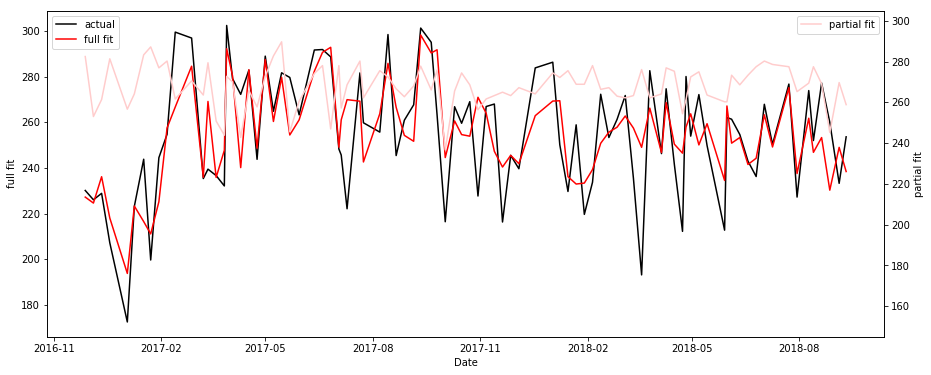

In [10]:
regress('tsnr', df2)

In [15]:
df3 = pd.read_csv('../data/extractions/anat.csv', parse_dates=['Date'])
df3

,Date,Filetype,snr_total,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,...,Shim5,Shim6,Shim7,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6
0,2017-10-30,acq-MPRAGE_T1w.json,45.609948,0.033092,39009,230.573,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
1,2017-11-06,acq-MPRAGE_T1w.json,49.575077,0.033160,41814,231.487,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.008877,0.953414,0.301535,0.001560,0.301560,-0.953446
2,2017-11-13,acq-MPRAGE_T1w.json,47.308825,0.033247,37638,231.326,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.149058,0.939970,0.306983,-0.065152,0.300441,-0.951573
3,2017-11-20,acq-MPRAGE_T1w.json,53.461779,0.033159,36473,229.930,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.148262,0.938058,0.313154,-0.040535,0.310623,-0.949669
4,2017-11-27,acq-MPRAGE_T1w.json,48.981048,0.033078,37165,227.070,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.159926,0.939737,0.302187,-0.040033,0.299701,-0.953193
5,2017-12-04,acq-MPRAGE_T1w.json,56.570965,0.033255,41697,231.932,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.007184,0.956126,0.292867,0.003875,0.292899,-0.956135
6,2017-12-18,acq-MPRAGE_T1w.json,46.212688,0.033263,35022,227.181,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.178403,0.937474,0.298855,-0.044262,0.295774,-0.954232
7,2018-01-02,acq-MPRAGE_T1w.json,54.843520,0.033227,42512,227.526,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.005452,0.957707,0.287694,0.001296,0.287705,-0.957718
8,2018-01-08,acq-MPRAGE_T1w.json,51.152603,0.028424,34889,231.071,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,-0.146475,0.942721,0.299703,-0.040477,0.297005,-0.954018
9,2018-01-15,acq-MPRAGE_T1w.json,56.041984,0.039198,36327,226.420,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146,...,-55,-88,-63,64,0.137367,0.941411,0.308019,0.048340,0.304225,-0.951373


Statistically significant variables: []
                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                    -364.594
Model:                            OLS   Adj. R-squared:               -490.267
Method:                 Least Squares   F-statistic:                    -2.901
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               1.00
Time:                        15:03:45   Log-Likelihood:                -234.52
No. Observations:                  44   AIC:                             493.0
Df Residuals:                      32   BIC:                             514.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SA

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  'rank is %d' % (J, J_), ValueWarning)


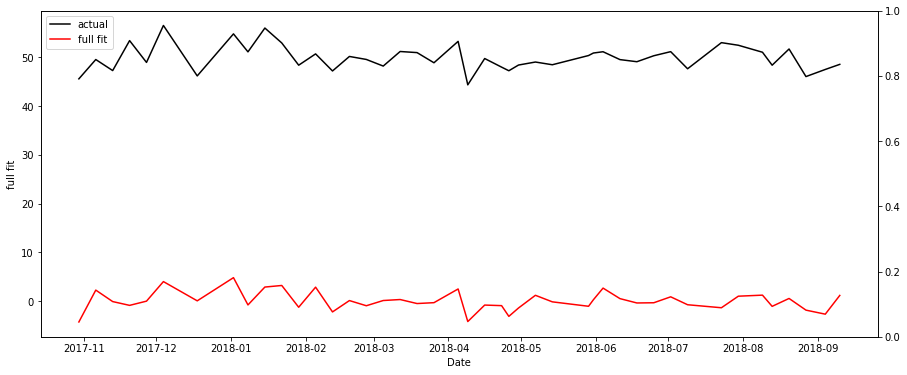

In [16]:
regress('snr_total', df3)

In [17]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
merged_df

,sid,ses,snr_total,TxRefAmp,AcquisitionTime,SAR,RepetitionTime,Shim1,Shim2,Shim3,...,Right-Accumbens-area,Right-Amygdala,Right-Caudate,Right-Hippocampus,Right-Pallidum,Right-Putamen,Right-Thalamus-Proper,csf,gray,white
Date_x,,,,,,,,,,,,,,,,,,,,,
2016-10-11,sub-sid000003,20161011X092931,12.176199,228.321,34773,0.046610,2.30,4153,-7690,-7492,...,442.968783,1688.027471,3268.476809,3543.750267,1760.800914,4587.099955,7838.965434,292997.718750,8.496853e+05,6.136589e+05
2017-02-14,sub-sid000005,20170214X120812,11.995018,258.474,44480,0.057880,2.30,4153,-7690,-7492,...,635.185595,1718.877083,4169.443674,4436.806975,1953.808741,5039.560927,8996.221381,279086.937500,9.059462e+05,7.412118e+05
2017-08-28,sub-sid000005,20170828X155317,13.083898,257.477,58313,0.059600,2.30,4153,-7690,-7492,...,594.052779,1803.515761,4095.088199,4337.930014,1979.912259,4977.070688,9061.084667,248674.781250,7.889210e+05,6.653368e+05
2017-08-29,sub-sid000005,20170829X171624,13.052024,265.239,62795,0.064612,2.30,4153,-7690,-7492,...,627.275438,1688.027471,4095.088199,4511.162449,1949.853663,5339.355871,9176.572957,281862.593750,8.714904e+05,7.198607e+05
2017-11-18,sub-sid000005,20171118X174426,13.184153,255.721,63930,0.055096,2.30,4146,-7686,-7488,...,621.738328,1703.847785,4100.625309,4282.558916,2001.269682,4947.012092,9038.936228,278994.406250,9.293572e+05,7.293204e+05
2017-02-13,sub-sid000007,20170213X131037,13.696513,253.806,48368,0.053773,2.30,4153,-7690,-7492,...,473.027379,1378.740338,3405.322522,4232.724928,1962.509914,5410.547283,9499.307356,214801.890625,7.374070e+05,6.415477e+05
2017-09-30,sub-sid000007,20170930X101910,12.540846,273.768,37228,0.070596,2.30,4146,-7686,-7488,...,435.849642,1431.738389,3410.068616,4318.945638,1967.256008,5504.678149,9863.965587,258066.468750,8.113044e+05,6.960376e+05
2017-10-04,sub-sid000007,20171004X101244,13.773062,264.229,36827,0.064534,2.30,4146,-7686,-7488,...,488.847693,1539.316522,3390.293224,4352.959312,1933.242333,5604.346125,9555.469470,248599.625000,8.340438e+05,6.870493e+05
2017-11-13,sub-sid000007,20171113X193049,13.851964,271.448,70745,0.068664,2.30,4146,-7686,-7488,...,491.220740,1546.435663,3423.515883,4352.959312,1979.912259,5609.092220,9606.094474,314915.968750,9.380308e+05,8.300230e+05


In [18]:
df3['Date'] = pd.to_datetime(df3['Date'], format="%Y%m%d")
df3.set_index('Date',inplace=True)
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
interpolated_df

,Filetype,snr_total,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,Shim2,...,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6,Seasonal (sin),Seasonal (cos),Date2
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,acq-MPRAGE_T1w.json,45.609948,0.033092,39009.000000,230.573000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-31,NaN,46.176395,0.033102,39409.714286,230.703571,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0
2017-11-01,NaN,46.742842,0.033112,39810.428571,230.834143,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0
2017-11-02,NaN,47.309289,0.033121,40211.142857,230.964714,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.554171,0.531484,0.138956,-0.122010,0.678457,-0.309418,-0.859077,0.508369,736635.0
2017-11-03,NaN,47.875736,0.033131,40611.857143,231.095286,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-04,NaN,48.442183,0.033141,41012.571429,231.225857,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.272647,0.742449,0.220246,-0.060225,0.490009,-0.631432,-0.841312,0.537808,736637.0
2017-11-05,NaN,49.008630,0.033150,41413.285714,231.356429,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-06,acq-MPRAGE_T1w.json,49.575077,0.033160,41814.000000,231.487000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,64.0,-0.008877,0.953414,0.301535,0.001560,0.301560,-0.953446,-0.823547,0.567248,736639.0
2017-11-07,NaN,49.251327,0.033173,41217.428571,231.464000,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,-0.028902,0.951493,0.302313,-0.007970,0.301400,-0.953178,-0.812961,0.580794,736640.0


In [19]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
super_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,Seasonal (sin),Seasonal (cos),Date2
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0


In [20]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
final_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,Seasonal (sin),Seasonal (cos),Date2,age,sex
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0,18,M
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0,19,M
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0,27,F
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0,27,M
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0,19,F
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0,21,F
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,31,M
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,18,F
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,19,F


In [21]:
# need to slice a prepared DataFrame first
real_data_df = pd.DataFrame(final_df,columns=['gray', 'age', 'sex', 'snr_total_qa'])
real_data_df = real_data_df.reset_index()
real_data_df = real_data_df.rename(columns={'Date_x': 'Date'})
real_data_df['sind'] = [0 for item in range(len(real_data_df))]
real_data_df.sind[real_data_df.sex == 'M'] = int(1)
real_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,gray,age,sex,snr_total_qa,sind
0,2017-10-30,8.646347e+05,18,M,45.609948,1
1,2017-10-30,7.388941e+05,19,M,45.609948,1
2,2017-10-31,6.797624e+05,27,F,46.176395,0
3,2017-11-01,7.363858e+05,27,M,46.742842,1
4,2017-11-03,6.829566e+05,19,F,47.875736,0
5,2017-11-03,5.824921e+05,21,F,47.875736,0
6,2017-11-05,7.327099e+05,31,M,49.008630,1
7,2017-11-05,1.023724e+06,18,F,49.008630,0
8,2017-11-05,7.930209e+05,19,F,49.008630,0
9,2017-11-05,8.361739e+05,19,M,49.008630,1


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'age', 'snr_total_qa', 'sind', 'Seasonal (sin)']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     6.482
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           2.24e-06
Time:                        15:04:02   Log-Likelihood:                -3526.9
No. Observations:                 261   AIC:                             7068.
Df Residuals:                     254   BIC:                             7093.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

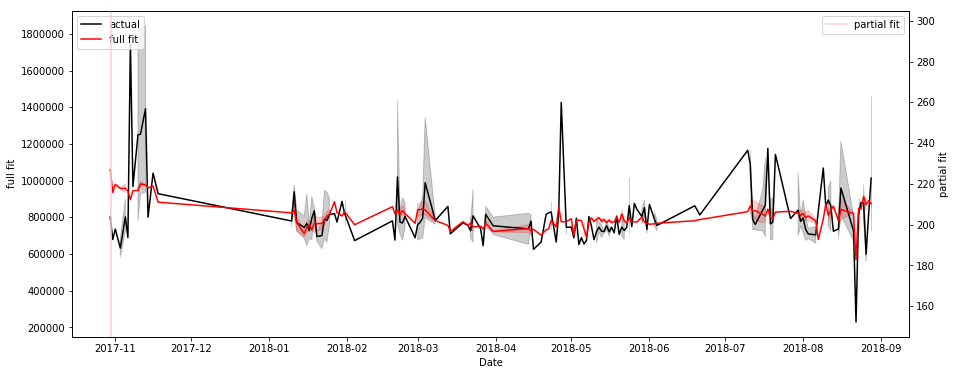

In [22]:
regress('gray', real_data_df)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Statistically significant variables: ['const', 'age', 'snr_total_qa', 'sind']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     6.387
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           3.10e-06
Time:                        15:04:09   Log-Likelihood:                -3131.3
No. Observations:                 236   AIC:                             6277.
Df Residuals:                     229   BIC:                             6301.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

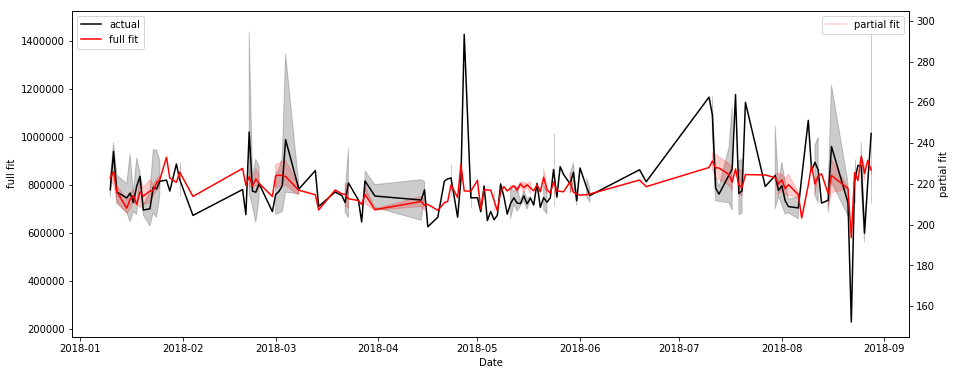

In [23]:
regress('gray', real_data_df.loc[25:])

In [109]:
# 'Background', "Left-Accumbens-area", 
#                                         "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
#                                         "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
#                                         "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
#                                         "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"
amyg_data_df = pd.DataFrame(final_df,columns=['csf', 'age', 'sex', 'snr_total_qa'])
amyg_data_df = amyg_data_df.reset_index()
amyg_data_df = amyg_data_df.rename(columns={'Date_x': 'Date'})
amyg_data_df['sind'] = [0 for item in range(len(amyg_data_df))]
amyg_data_df.sind[amyg_data_df.sex == 'M'] = int(1)
amyg_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,csf,age,sex,snr_total_qa,sind
0,2017-10-30,264707.875000,18,M,45.609948,1
1,2017-10-30,234300.421875,19,M,45.609948,1
2,2017-10-31,218291.046875,27,F,46.176395,0
3,2017-11-01,255414.984375,27,M,46.742842,1
4,2017-11-03,549233.812500,19,F,47.875736,0
5,2017-11-03,213185.031250,21,F,47.875736,0
6,2017-11-05,224194.390625,31,M,49.008630,1
7,2017-11-05,505816.531250,18,F,49.008630,0
8,2017-11-05,242355.328125,19,F,49.008630,0
9,2017-11-05,309665.250000,19,M,49.008630,1


In [121]:
expanded_df = pd.DataFrame(final_df,columns=['sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white", 'age', 
                                             'sex', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                             'IOPD4_real', 'IOPD5_real', 'IOPD6_real'])
expanded_df = expanded_df.reset_index()
expanded_df = expanded_df.rename(columns={'Date_x': 'Date'})
expanded_df['sind'] = [0 for item in range(len(expanded_df))]
expanded_df.sind[expanded_df.sex == 'M'] = int(1)
expanded_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,Left-Putamen,...,age,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind
0,2017-10-30,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,6025.166470,...,18,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1
1,2017-10-30,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,5393.935953,...,19,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1
2,2017-10-31,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,4594.219096,...,27,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0
3,2017-11-01,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,5674.746521,...,27,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1
4,2017-11-03,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,4542.012061,...,19,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0
5,2017-11-03,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,5116.289448,...,21,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0
6,2017-11-05,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,5669.209412,...,31,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1
7,2017-11-05,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,5147.930075,...,18,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0
8,2017-11-05,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,4536.474951,...,19,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0
9,2017-11-05,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,5586.152765,...,19,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1


In [122]:
tsnr_df = pd.DataFrame(df,columns=['Date', 'tsnr'])
tsnr_df.set_index('Date',inplace=True)
tsnr_df_reindexed = tsnr_df.reindex(pd.date_range(start=tsnr_df.index.min(), end=tsnr_df.index.max(), freq='1D'))  
tsnr_df_reindexed.index.names = ['Date']
interpolated_tsnr_df = tsnr_df_reindexed.interpolate(method='time')
interpolated_tsnr_df

new_df = pd.merge(interpolated_tsnr_df, expanded_df, on=['Date'], how='right')
new_df

,Date,tsnr,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,...,age,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind
0,2017-10-30,180.321930,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,...,18,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1
1,2017-10-30,180.321930,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,...,19,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1
2,2017-10-31,189.864031,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,...,27,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0
3,2017-11-01,199.406132,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,...,27,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1
4,2017-11-03,218.490335,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,...,19,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0
5,2017-11-03,218.490335,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,...,21,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0
6,2017-11-05,237.574537,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,...,31,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1
7,2017-11-05,237.574537,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,...,18,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0
8,2017-11-05,237.574537,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,...,19,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0
9,2017-11-05,237.574537,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,...,19,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1


In [123]:
dicom_data = pd.read_csv('../output/dicom_data.csv')
dicom_data = pd.DataFrame(dicom_data,columns=['sid', 'ses', 'PatientWeight'])
July17_df = pd.merge(new_df, dicom_data, on=['sid', 'ses'], how='left')
July17_df

,Date,tsnr,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,...,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind,PatientWeight
0,2017-10-30,180.321930,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,...,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1,131.541804
1,2017-10-30,180.321930,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,...,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1,64.410125
2,2017-10-31,189.864031,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,...,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0,56.699053
3,2017-11-01,199.406132,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,...,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1,70.306826
4,2017-11-03,218.490335,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,...,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0,63.502940
5,2017-11-03,218.490335,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,...,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0,52.616722
6,2017-11-05,237.574537,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,...,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1,84.368192
7,2017-11-05,237.574537,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,...,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0,63.502940
8,2017-11-05,237.574537,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,...,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0,52.163129
9,2017-11-05,237.574537,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,...,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1,86.182561


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'IOPD3_real', 'IOPD5_real', 'PatientWeight']
                            OLS Regression Results                            
Dep. Variable:                    csf   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.400
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           4.83e-05
Time:                        16:05:02   Log-Likelihood:                -3279.4
No. Observations:                 261   AIC:                             6589.
Df Residuals:                     246   BIC:                             6642.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

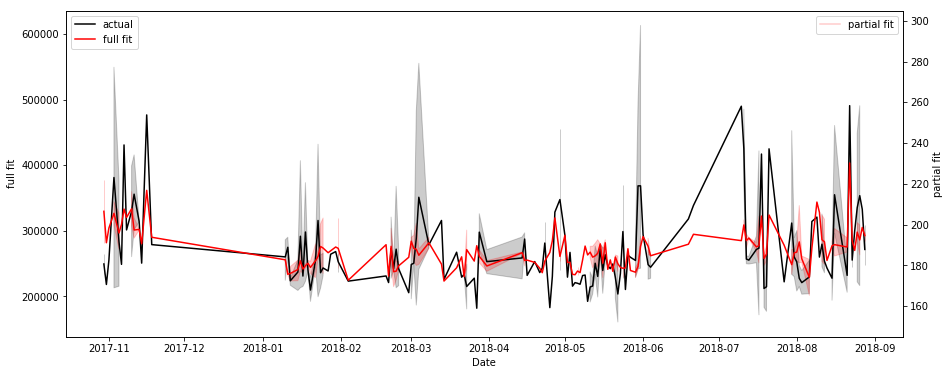

In [114]:
hello = regress('csf', July17_df)

In [151]:
def scrape_var_significance(targets, p_var, df):
    columns = ['Variable', p_var + ' p value', 'R2 value']
    result = pd.DataFrame(columns = columns)
    
    for target in targets:
        input_df = pd.DataFrame(df,columns=['Date', 'sid', 'ses', target, 'age', 'tsnr',
                                             'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                             'IOPD4_real', 'IOPD5_real', 'IOPD6_real', 'sind', 'PatientWeight'])
        model = regress(target, input_df, plot=False, print_summary=False)
        result.loc[len(result)] = [target, model.pvalues[p_var], model.rsquared]
        
    return result

In [152]:
targets = ['Background', "Left-Accumbens-area", "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"]
scrape_var_significance(targets, 'snr_total_qa', July17_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,Variable,snr_total_qa p value,R2 value
0,Background,0.205616,0.472111
1,Left-Accumbens-area,0.727514,0.108272
2,Left-Amygdala,0.496588,0.330530
3,Left-Caudate,0.413241,0.232360
4,Left-Hippocampus,0.622114,0.223448
5,Left-Pallidum,0.579991,0.521963
6,Left-Putamen,0.352507,0.271780
7,Left-Thalamus-Proper,0.210170,0.432351
8,Right-Accumbens-area,0.295446,0.151464
9,Right-Amygdala,0.436955,0.336576
